Methods

* Load & Merge the Datasets (if they have common fields).
* Check for Regional and Malaria Intervention Data (e.g., bed net usage, healthcare access).

Compare Interventions Across Regions:
* Use boxplots & bar charts to show disparities.

Analyze Malaria Outcomes by Region:
* Compare malaria prevalence rates across regions.
* Use ANOVA to check if differences are statistically significant.

Perform a Regression Analysis:
* Model how interventions impact malaria prevalence in different regions.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_main  = pd.read_csv('Malaria screener.csv')
df_age  = pd.read_csv('Malaria data.csv')

In [3]:
# Merge datasets (if necessary)
if 'ID' in df_main.columns and 'ID' in df_age.columns:
    df = pd.merge(df_main, df_age, on='ID', how='inner')  # Merge on ID
else:
    df = pd.concat([df_main, df_age], axis=1)  # Merge by column order

In [4]:
# Convert columns to numeric, forcing non-numeric values to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' turns non-numeric values into NaN

In [5]:
# Fill NaN with Normal Distribution (Mean & Std)
for col in df.columns:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = df[col].apply(lambda x: np.random.normal(mean_val, std_val) if pd.isna(x) else x)

In [6]:
# Select relevant columns, (Identify Region, Malaria, and Intervention Columns)
selected_columns = ['SHREGION','ITN_Coverage_2020','Malaria_Prevalence_2020']

# Check for missing values in the selected columns
missing_values = df[selected_columns].isnull().sum()
df = df[selected_columns].dropna()

# Display summary of the cleaned dataset
df.describe(), missing_values

(           SHREGION  ITN_Coverage_2020  Malaria_Prevalence_2020
 count  70428.000000       70428.000000             70428.000000
 mean       3.208568           0.388280                 0.271146
 std        1.634262           0.197998                 0.128697
 min        1.000000          -0.445695                -0.248308
 25%        2.000000           0.254246                 0.185059
 50%        3.000000           0.387730                 0.270771
 75%        5.000000           0.521677                 0.357709
 max        6.000000           1.256562                 0.804593,
 SHREGION                   0
 ITN_Coverage_2020          0
 Malaria_Prevalence_2020    0
 dtype: int64)

In [7]:
# Group by Region and Calculate Mean Values
grouped_data = df.groupby(['SHREGION'])['Malaria_Prevalence_2020', 'ITN_Coverage_2020'].mean().reset_index()
grouped_data.rename(columns={'Malaria_Prevalence_2020': 'Average_Prevalence'}, inplace=True)
print("\nSummary Statistics:\n", grouped_data)


Summary Statistics:
    SHREGION  Average_Prevalence  ITN_Coverage_2020
0         1            0.271039           0.388349
1         2            0.270324           0.388092
2         3            0.269905           0.388986
3         4            0.272115           0.387288
4         5            0.273367           0.387291
5         6            0.271799           0.388948


##  Visualizes regional disparities in malaria prevalence & intervention coverage.

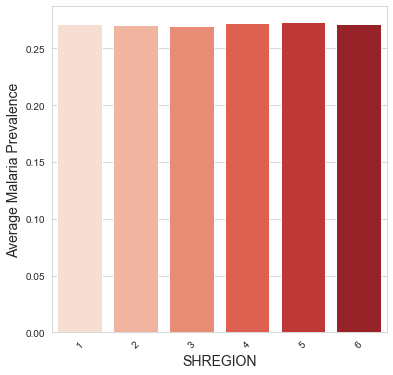

In [11]:
# Plot Malaria Prevalence Across Regions
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, x='SHREGION', y='Average_Prevalence', palette='Reds')
plt.xticks(rotation=45)
plt.xlabel('SHREGION', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
#plt.title("Malaria Prevalence by Region")
plt.show()

In [ ]:
     Malaria Prevalence by Region

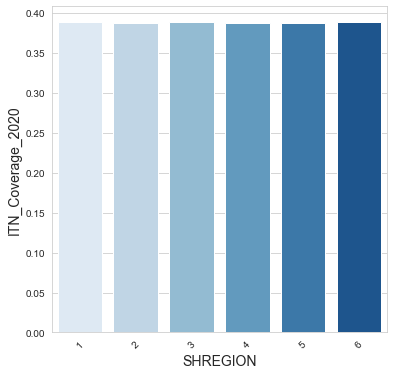

In [12]:
# Plot Intervention Coverage Across Regions
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, x='SHREGION', y='ITN_Coverage_2020', palette='Blues')
plt.xticks(rotation=45)
plt.xlabel('SHREGION', fontsize=14)
plt.ylabel('ITN_Coverage_2020', fontsize=14)
#plt.title("Intervention Coverage by Region")
plt.show()

   Intervention Coverage by Region

### ANOVA test checks if malaria rates differ significantly by region

In [28]:
# ANOVA Test
anova_data = df.groupby(['SHREGION', 'ITN_Coverage_2020'])['Malaria_Prevalence_2020']
groups = [values for (_, _), values in anova_data]

f_stat, p_value = f_oneway(*groups)
print("\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant differences exist.")
else:
    print("No significant differences found.")


ANOVA Results:
F-statistic: inf, P-value: 0.0000e+00
Statistically significant differences exist.


### Regression model estimates how interventions reduce malaria prevalence.

In [23]:
# Regression: How Intervention Affects Malaria Prevalence
X = df['ITN_Coverage_2020'].values.reshape(-1, 1)
y = df['Malaria_Prevalence_2020'].values

In [24]:
reg_model = LinearRegression()
reg_model.fit(X, y)
r2 = reg_model.score(X, y)

In [26]:
print(f"\n🎯 Regression Analysis: R² = {r2:.4f} (Intervention impact on Malaria)")


🎯 Regression Analysis: R² = 0.0001 (Intervention impact on Malaria)
